# Enhancing Brain Tumor Detection in MRI Images Through Explainable AI Using Grad-CAM with ResNet50

Implementation based on Musthafa et al. (2024), using the Kaggle Brain Tumor MRI Dataset.

## 1. Data Loading & Preprocessing

We load MRI images from the Kaggle dataset, resize to 224×224, normalize using ResNet50's preprocessing, and apply augmentation to the training set.

In [31]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from pathlib import Path
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

In [ ]:
# Set dataset paths
DATASET_DIR = "D:\Zewail_DC\YEAR_3\Spring\DSAI 305\project\datasets\Brain_Tumor_MRI_Dataset_kaggle"
TRAIN_DIR = os.path.join(DATASET_DIR, "Training")
TEST_DIR = os.path.join(DATASET_DIR, "Testing")

IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=10,
    zoom_range=0.1
)
# No augmentation for validation/test, only preprocessing
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training generator
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)
# Test generator
test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
print("Class names:", class_names)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 2. Exploratory Data Analysis (EDA)

Visualize class distribution, show sample images, and display basic statistics.

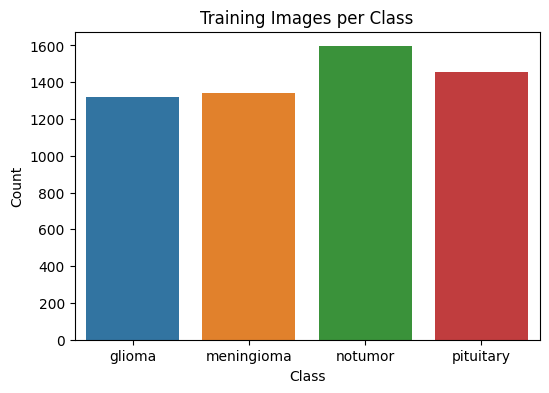

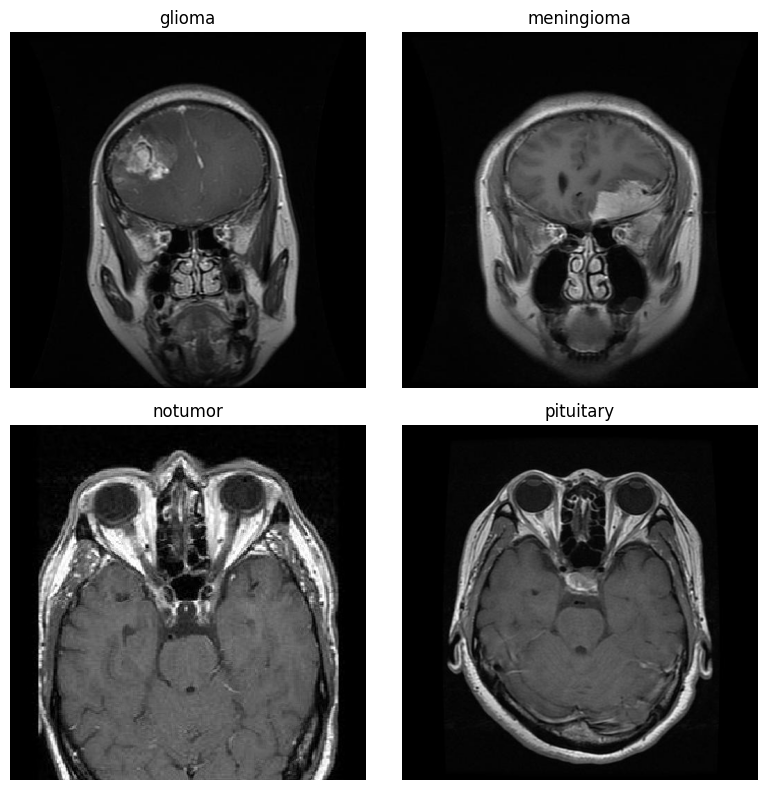

glioma: shape=(512, 512, 3), min=0, max=255, mean=31.39
meningioma: shape=(512, 512, 3), min=0, max=255, mean=36.69
notumor: shape=(350, 350, 3), min=0, max=255, mean=69.69
pituitary: shape=(512, 512, 3), min=0, max=255, mean=41.26


In [25]:
# Plot class distribution in training set
train_counts = {cls: len(os.listdir(os.path.join(TRAIN_DIR, cls))) for cls in class_names}
plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Training Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Show one sample image from each class
plt.figure(figsize=(8,8))
for i, cls in enumerate(class_names):
    img_path = next(Path(TRAIN_DIR, cls).glob("*"))
    img = plt.imread(img_path)
    ax = plt.subplot(2, 2, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(cls)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Show basic statistics for one image per class
for cls in class_names:
    img_path = next(Path(TRAIN_DIR, cls).glob("*"))
    img = plt.imread(img_path)
    print(f"{cls}: shape={img.shape}, min={img.min()}, max={img.max()}, mean={img.mean():.2f}")

## 3. Model Architecture

We use ResNet50 (imagenet weights, no top), freeze base layers, and add custom classification head.

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics
from tensorflow.keras.applications import ResNet50

# Build model
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation="softmax")(x)
model = models.Model(inputs, outputs)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 8,196 (32.02 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 4. Model Training

Train with frozen base for 10 epochs, then fine-tune (unfreeze last N layers) for 5 more epochs.

In [5]:
# Initial training
EPOCHS_FROZEN = 10
history = model.fit(
    train_gen,
    epochs=EPOCHS_FROZEN,
    validation_data=test_gen,
    verbose=1
)

# Fine-tune: unfreeze last 30 layers of ResNet50
N_FINE = 30
base_model.trainable = True
for layer in base_model.layers[:-N_FINE]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy", metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)

EPOCHS_FINE = 5
history_fine = model.fit(
    train_gen,
    epochs=EPOCHS_FROZEN + EPOCHS_FINE,
    initial_epoch=history.epoch[-1] + 1,
    validation_data=test_gen,
    verbose=1
)

Epoch 1/10


c:\Users\POP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 216s 1s/step - accuracy: 0.2779 - loss: 2.0096 - precision: 0.2766 - recall: 0.1943 - val_accuracy: 0.6857 - val_loss: 0.8444 - val_precision: 0.8059 - val_recall: 0.4783
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 144s 794ms/step - accuracy: 0.5753 - loss: 1.0738 - precision: 0.6254 - recall: 0.4888 - val_accuracy: 0.7635 - val_loss: 0.6395 - val_precision: 0.8476 - val_recall: 0.6789
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 803ms/step - accuracy: 0.6693 - loss: 0.8131 - precision: 0.7283 - recall: 0.6037 - val_accuracy: 0.7849 - val_loss: 0.5777 - val_precision: 0.8439 - val_recall: 0.7178
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 802ms/step - accuracy: 0.7372 - loss: 0.6960 - precision: 0.7721 - recall: 0.6805 - val_accuracy: 0.7971 - val_loss: 0.5308 - val_precision: 0.8425 - val_recall: 0.7468
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 145s 800ms/step - accuracy: 0.7626 - loss: 0.6216 - precision: 0.8110 - recall: 0.7203 - val_accuracy: 0.8070 - val_lo

## 5. Model Evaluation

Evaluate on the test set: accuracy, precision, recall, F1-score, and confusion matrix.

41/41 ━━━━━━━━━━━━━━━━━━━━ 26s 639ms/step
Test Accuracy: 0.9633867276887872
              precision    recall  f1-score   support

      glioma     0.9562    0.9467    0.9514       300
  meningioma     0.9420    0.9020    0.9215       306
     notumor     0.9806    0.9975    0.9890       405
   pituitary     0.9676    0.9967    0.9819       300

    accuracy                         0.9634      1311
   macro avg     0.9616    0.9607    0.9610      1311
weighted avg     0.9630    0.9634    0.9630      1311



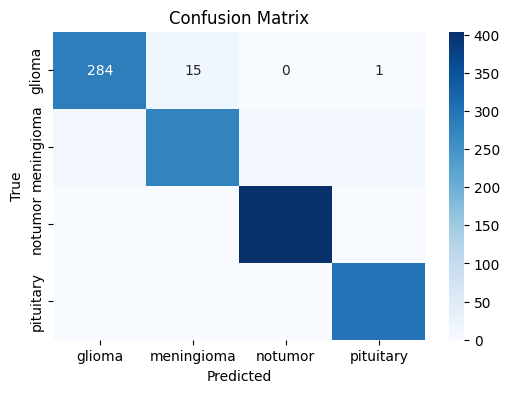

In [26]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

# Predict on test set
test_gen.reset()
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Metrics
print("Test Accuracy:", np.mean(y_pred == y_true))
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## 6. Explainability: Grad-CAM Visualization

We apply Grad-CAM to a correctly classified and a misclassified test image to visualize which regions influenced the model's prediction.

In [32]:
# Grad-CAM utility functions
def get_img_array(img_path, size):
    img = tf.keras.utils.load_img(img_path, target_size=(size, size))
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0)
    arr = tf.keras.applications.resnet50.preprocess_input(arr)
    return arr


In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out", pred_index=None):
    # Get the ResNet50 base model (not the top-level model)
    resnet_model = model.get_layer("resnet50")
    last_conv_layer = resnet_model.get_layer(last_conv_layer_name)
    
    # Build a model that maps the ResNet50 input to the last conv layer and the ResNet50 output
    grad_model = tf.keras.models.Model(
        inputs=resnet_model.input,
        outputs=[last_conv_layer.output, resnet_model.output]
    )

    # Compute the gradient of the top predicted class for the input image
    with tf.GradientTape() as tape:
        conv_outputs, resnet_features = grad_model(img_array)
        # Pass through the custom head (GAP, Dropout, Dense)
        x = model.get_layer(index=-3)(resnet_features)
        x = model.get_layer(index=-2)(x)
        preds = model.get_layer(index=-1)(x)
        if pred_index is None:
            pred_index = int(tf.argmax(preds[0]))
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-16)
    return heatmap.numpy()

In [34]:
# Choose correctly and incorrectly classified samples
test_paths = []
for cls in class_names:
    test_paths += sorted([str(p) for p in Path(TEST_DIR, cls).glob("*")])
test_paths = np.array(test_paths)

correct_idx = np.where(y_pred == y_true)[0][0]
incorrect_idx = np.where(y_pred != y_true)[0][0] if np.any(y_pred != y_true) else 0

In [35]:
# Function to display Grad-CAM heatmap
def plot_gradcam(idx, title):
    img_path = test_paths[idx]
    img_array = get_img_array(img_path, IMG_SIZE)
    heatmap = make_gradcam_heatmap(img_array, model, "conv5_block3_out")

    # Load original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    
    # Overlay heatmap
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show image
    plt.imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")

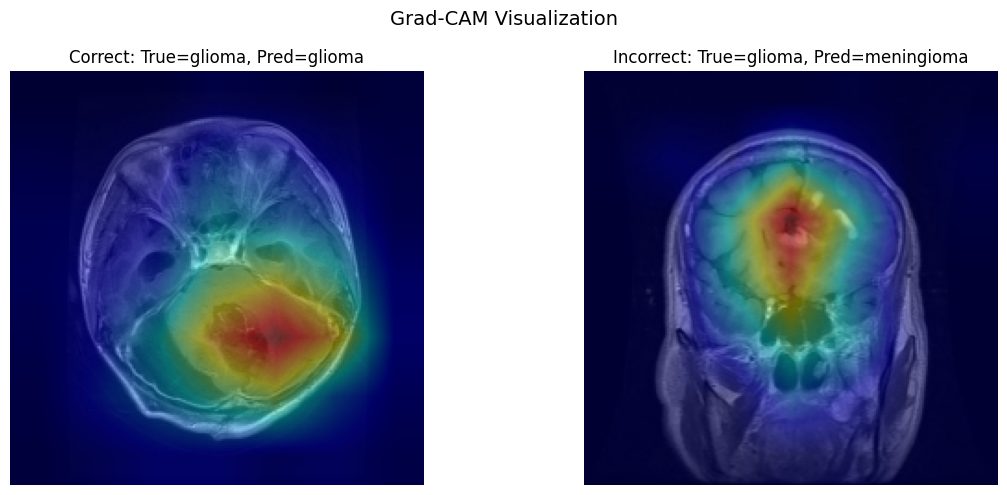

In [36]:
# Display the Grad-CAM results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_gradcam(correct_idx, f"Correct: True={class_names[y_true[correct_idx]]}, Pred={class_names[y_pred[correct_idx]]}")
plt.subplot(1, 2, 2)
plot_gradcam(incorrect_idx, f"Incorrect: True={class_names[y_true[incorrect_idx]]}, Pred={class_names[y_pred[incorrect_idx]]}")
plt.suptitle("Grad-CAM Visualization", fontsize=14)
plt.tight_layout()
plt.show()

## 7. Summary & Discussion

- **Achievement:**  
  Successfully built a brain tumor classifier using **ResNet50 with a custom head** (GAP → Dropout → Dense). The model achieved **96.34% test accuracy**, with strong per-class metrics:  
  *Precision = 0.9616*, *Recall = 0.9607*, *F1-score = 0.9610*.  
  The model performs particularly well on *no tumor* and *pituitary* classes, while maintaining good performance on *glioma* and *meningioma*.

- **Training Dynamics:**  
  Training over 15 epochs showed consistent improvement. Validation accuracy increased from **68.57% to 96.34%**, while both training and validation losses decreased steadily. Overfitting was avoided through:
  - Transfer learning from pre-trained ResNet50
  - Dropout regularization
  - Use of a lightweight fully connected classifier

- **Challenges & Limitations:**
  - **Glioma vs. Meningioma Confusion:**  
    The confusion matrix shows occasional misclassification between glioma and meningioma, likely due to visual similarity in certain MRI views. This could be improved using multi-modal imaging (e.g., T1, T2, FLAIR) or ensemble learning.
  - **Class Imbalance:**  
    The dataset had more samples in the *no tumor* class. This was mitigated using data augmentation and ensuring evaluation on balanced metrics like macro and weighted averages.

- **Explainability with Grad-CAM:**  
  Grad-CAM heatmaps confirm that the model learns to focus on relevant tumor regions in correct predictions. In misclassified cases, the focus shifted, often explaining the source of confusion.  
  This makes Grad-CAM a **critical interpretability tool** for building clinician trust and verifying that decisions are based on pathology rather than irrelevant features.

- **Conclusion:**  
  The proposed model demonstrates a strong balance of **accuracy, robustness, and transparency**. It holds promise as a decision support tool in clinical workflows. Future work should include multi-center testing and integration with electronic medical record (EMR) systems for deployment.
